# Bayesian Portfolio Optimization using MCMC
**Authors**
- Jingyi Fan, jf4258@nyu.edu, N15191508
- Tianyu Li, tl3472@nyu.edu, N18586573
- Wenxin Zhang, wz2127@nyu.edu, N15067695


## Part 1: Portfolio optimization problem by using Monte Carlo simulation 
- Choose 30-40 stocks
- Find the most optimal portfolio weight and corresponding expected return
- Graph: Efficient Frontier with 3 portfolio (min risk, optimal, max return)


## Part 2: MCMC
- Theoretical foundation
- Use Metropolis Algorithm to find the  posterior distribution as histogram
- Graph: resulting posterior distribution 

Sample Graph:

![SamplePosterior.png](SamplePosterior.png)

Compare the optimal stock return from Monte Carlo and from MCMC distribution.

**References**
- https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/master/StockPricePrediction.py
- https://www.datacamp.com/community/tutorials/lstm-python-stock-market
- https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98

## Data
- Source: Daily returns data from CRSP database from WRDS, 
- Variable: permno (company code), date, ret (return of the stock)
- Sample: we only keep companies from S&P 500 index.

In [34]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

%matplotlib inline

## Data

In [35]:
ticker = 'aapl'
start = '2000-1-1'
end = '2022-12-10'

stock_data = yf.download(ticker, start, end, adjusted=True)

ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date',"Mkt-RF": "Mkt_RF"}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 completed


In [36]:
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "aapl"
ff_data = ff3_monthly.merge(stock_returns,on='Date')

In [37]:
ff_data

,Mkt_RF,SMB,HML,RF,aapl
Date,,,,,
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.104820
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.184842
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086517
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,-0.322922
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.247024
...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0377,0.0139,0.0031,0.0019,-0.031208


## Fama French Three factors model

$$ R_{it} - R_{ft} = \alpha_{it} + \beta_{1}(R_{mt}-R_{ft}) + \beta_{2} \text{SMB}_t + \beta_{3} \text{HML}_t + \sigma\epsilon_{it}$$

In [38]:
y = np.array(ff_data['aapl'] - ff_data['RF'])
x1 = np.array(ff_data['Mkt_RF'])
x2 = np.array(ff_data['SMB'])
x3 = np.array(ff_data['HML'])

In [39]:
m = pm.Model()

with m:
    # Observed data
    it_RF = pm.Data("it_RF", y)
    Mkt_RF = pm.Data("Mkt_RF", x1)
    SMB = pm.Data("SMB", x2)
    HML = pm.Data("HML", x3)

    # Priors
    alpha_it = pm.Normal("alpha_it", 0.0, 1.0)
    beta_1 = pm.Normal("beta_1", 0.0, 1.0)
    beta_2 = pm.Normal("beta_2", 0.0, 1.0)
    beta_3 = pm.Normal("beta_3", 0.0, 1.0)
    sigma = pm.Uniform("sigma", 0.001, 1.0)

    # Likelihood (as denoted by `observed`)
    obs_it_RF = pm.Normal("obs_it_RF", alpha_it + beta_1*Mkt_RF + beta_2*SMB + beta_3*HML, sigma, observed=it_RF)

In [40]:
with m:
    trace = pm.sample(2000, tune=1500)

/Users/clairefan/.local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_3, beta_2, beta_1, alpha_it]


/Users/clairefan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/clairefan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/clairefan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/clairefan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 18 seconds.


Text(0.5, 1.0, 'sigma')

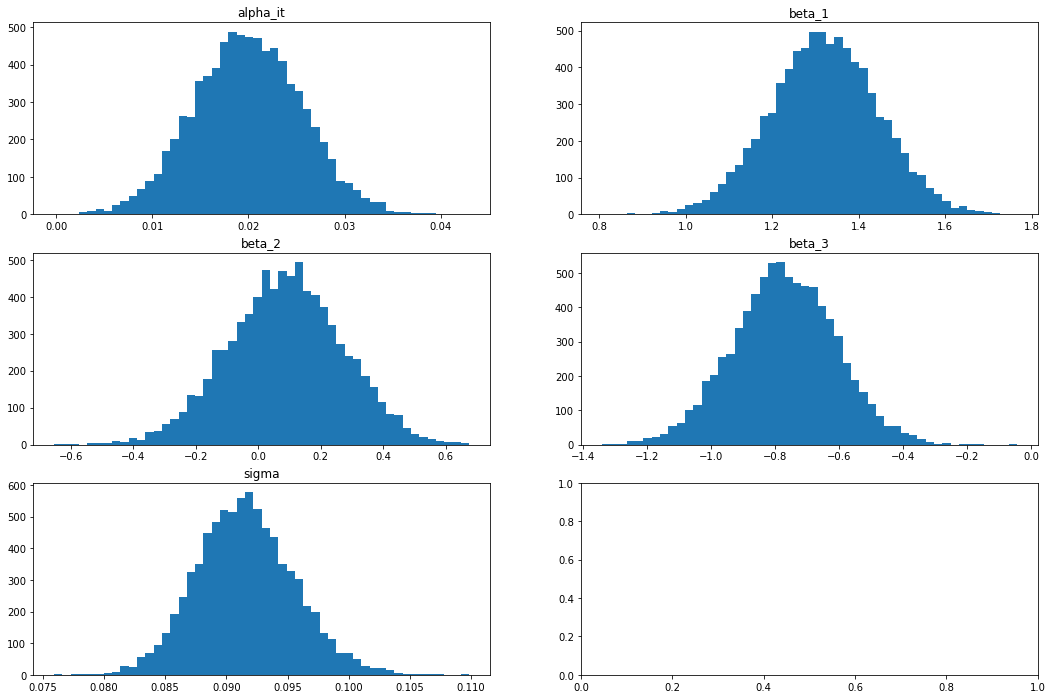

In [41]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12))

ax[0, 0].hist(trace["alpha_it"], bins=50)
ax[0, 0].set_title("alpha_it")
ax[0, 1].hist(trace["beta_1"], bins=50)
ax[0, 1].set_title("beta_1")
ax[1, 0].hist(trace["beta_2"], bins=50)
ax[1, 0].set_title("beta_2")
ax[1, 1].hist(trace["beta_3"], bins=50)
ax[1, 1].set_title("beta_3")
ax[2, 0].hist(trace["sigma"], bins=50)
ax[2, 0].set_title("sigma")

In [42]:
# Predict the return with all history data
pre_ret_all = ff_data["RF"] + trace["alpha_it"].mean() + trace["beta_1"].mean()*ff_data["Mkt_RF"] + \
    trace["beta_2"].mean()*ff_data["SMB"] + trace["beta_3"].mean()*ff_data["HML"] + trace["sigma"].mean()
pre_ret_all = pd.DataFrame(pre_ret_all)
pre_ret_all.columns = ['aapl']
pre_ret_all

,aapl
Date,
2000-02-29,0.241615
2000-03-31,0.106878
2000-04-30,-0.030256
2000-05-31,0.015722
2000-06-30,0.253010
...,...
2022-06-30,0.048687
2022-07-31,0.272789
2022-08-31,0.062431


In [43]:
# Predict return with the second latest data (2022-09-30)
pre_ret = ff_data.iloc[-2].RF + trace["alpha_it"].mean() + trace["beta_1"].mean()*ff_data.iloc[-2].Mkt_RF + \
    trace["beta_2"].mean()*ff_data.iloc[-2].SMB + trace["beta_3"].mean()*ff_data.iloc[-2].HML + trace["sigma"].mean()
pre_ret

-0.01101275882741165

In [ ]:
# Calculate the real profit based on the latest data (2022-10-31)